# Cholera

In [1]:

import os
#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

import jax
import itertools
import numpy as onp
import ptitprince as pt

import jax.numpy as np
import ipywidgets as widgets
import pandas as pd

from jax.numpy.linalg import inv, pinv
from jax.scipy.optimize import minimize
from scipy.linalg import solve_discrete_are as dare
from jax import jit, grad
from IPython import display
from toolz.dicttoolz import valmap, itemmap
from itertools import chain
from functools import partial

from tqdm.notebook import tqdm
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

from pomps import *
from resampling import *
from filtering import *
from optim import *


import matplotlib.pyplot as plt
plt.style.use('matplotlibrc')
onp.set_printoptions(suppress=True)

2024-07-18 20:25:19.931115: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
dataset = pd.read_csv('data/dacca/dacca.csv', index_col=0).reset_index(drop=True)
ys = np.array(dataset['cholera.deaths'].values)
dataset = pd.read_csv('data/dacca/covars.csv', index_col=0).reset_index(drop=True)
dataset.index = pd.read_csv('data/dacca/covart.csv', index_col=0).reset_index(drop=True).squeeze()
dataset = dataset.reindex(onp.array([1891 + i*(1/240) for i in range(12037)])).interpolate()
covars = np.array(dataset.values)#[20:]
#gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, k, delta = 8.0, 9.238, 7.1, 0.7, onp.exp(-4.5), 0.0051, (-6.8*10**(-3)), 639.6, 0.23, np.array([6.5,11.4,2.1,9.0,8.6,9.5]), 3, 0.02
#gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, k, delta = 17.3, 0.057, 0, 9.8, onp.exp(-4.8), 0.999999, (-5.0*10**(-3)), 3.2, 0.25, np.array([1.2,6.2,-3.4,3.9,3.2,4.3]), 3, 0.02


gamma = 20.8
epsilon = 19.1
rho = 0
delta = 0.02
m = 0.06
c = np.array(1)
beta_trend = -0.00498
bs = np.array([0.747, 6.38, -3.44, 4.23, 3.33, 4.55])
sigma = 3.13 #3.13 # 0.77
tau = 0.23 
omega = onp.exp(-4.5)
omegas = np.log(np.array([0.184, 0.0786, 0.0584, 0.00917, 0.000208, 0.0124]))


theta = transform_thetas(gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, omegas)

In [15]:
reps = [pfilter(theta, ys, 10000+i, covars, thresh=-1) for i in range(30)]

In [16]:
onp.std(reps)

0.5843911

In [18]:
onp.mean(reps)

3748.597

In [17]:
0.5843911*3

1.7531733000000003

In [3]:
mop(theta, ys, 10000, covars, alpha=0.5)

Array(3749.1624, dtype=float32)

In [7]:
jgrad(theta, ys, 10000, covars, -1)

Array([-0.19687533, -0.03858373,  0.        ,  0.00286964,  0.        ,
        0.        , -0.12418063, -0.08954981, -0.01173791,  0.04419267,
        0.02424683,  0.00042992,  0.06725463,  0.18432611,  0.10544084,
       -0.00084148,  0.00101419, -0.01850539, -0.02044537,  0.00072716,
       -0.00293363], dtype=float32)

In [3]:
n_trials = 100
J = 10000

def get_rand_theta():
    return transform_thetas(onp.random.uniform(10.00, 40.00),
                onp.random.uniform(0.03, 0.60), 
                         rho, 
                 onp.random.uniform(0.20, 30.00), 
                         omega, 
                         c, 
                 onp.random.uniform(-1.00, 0.00)*0.01, 
                 onp.random.uniform(1.00, 5.00), 
                 onp.random.uniform(0.10, 0.50), 
                 onp.random.uniform(0,8,size=6)+np.array([-4,0,-4,0,0,0]), 
                 onp.random.uniform(-10,0,size=6))

def get_sds():    
    lows = transform_thetas(10.00,0.03, rho, 0.20, omega, c, 
             -1.00*0.01, 1.00, 0.10, 
             onp.zeros(6)+onp.array([-4,0,-4,0,0,0]), 
            -10*onp.ones(6))
    highs = transform_thetas(40.00,0.60, rho, 30.00, omega, c, 
                 0.00, 5.00, 0.50, 
                 8*onp.ones(6)+onp.array([-4,0,-4,0,0,0]), 
                onp.zeros(6))
    return (highs-lows)/100



def get_rand_theta(J=J):
    lows = transform_thetas(10.00,0.03, rho, 0.20, omega, c, 
             -1.00*0.01, 1.00, 0.10, 
             onp.zeros(6)+onp.array([-4,0,-4,0,0,0]), 
            -10*onp.ones(6))
    highs = transform_thetas(40.00,0.60, rho, 30.00, omega, c, 
                 0.00, 5.00, 0.50, 
                 8*onp.ones(6)+onp.array([-4,0,-4,0,0,0]), 
                onp.zeros(6))
    rands = onp.array(onp.repeat(((lows+highs)/2)[None,:], J, axis=0)).T
    rands[~onp.isinf(lows)] = onp.random.uniform(lows[~onp.isinf(lows)], 
                       highs[~onp.isinf(highs)],
                       size=(J, len(highs[~onp.isinf(highs)]))).T
    return rands.T
                       
                       


sigmas = (np.abs(theta)/600)
theta_ests = theta + 60*sigmas*onp.random.normal(size=theta.shape) #6 for close to maxima
#theta_ests = get_rand_theta(J).mean(0)

'''
gd_logliks, gd_ests = train(theta_ests, ys, covars, beta=0.9, eta=5e-4/600,
                            verbose=True, itns=20, J=J, thresh=0, method='SGD', scale=False)


newt_logliks, newt_ests = train(theta_ests, ys, covars, beta=0.9, eta=1e-2, c=1e-1, max_ls_itn=5, 
                            verbose=True, itns=20, J=J, Jh=500, thresh=0, method='Newton', scale=True, ls=True)

'''
print(pfilter(theta_ests, ys, J, covars, thresh=-1))
#res = minimize(pfilter, x0=theta_ests, args=(ys, J, covars, 0), method='BFGS', options={'maxiter': 10})
get_thetas(theta_ests)

# try cross-comparison, fig 2 in pnas, on close to MLE
# use if2 settings

4010.2856


(Array(21.47103, dtype=float32),
 Array(0.03650291, dtype=float32),
 Array(nan, dtype=float32),
 Array(24.130589, dtype=float32),
 Array(0.01128119, dtype=float32),
 Array(nan, dtype=float32),
 Array(-0.00479114, dtype=float32),
 Array(2.9340549, dtype=float32),
 Array(0.20998566, dtype=float32),
 Array([ 0.7661563,  7.322663 , -3.0760021,  4.156569 ,  3.334692 ,
         4.926099 ], dtype=float32),
 Array([-2.084508 , -2.5867274, -2.8861308, -4.956059 , -9.343757 ,
        -4.909674 ], dtype=float32),
 3,
 0.02)

In [4]:
def log_in_bbox(theta):    
    valids = np.array([i for i in range(len(theta)) if i not in [2,5]])
    lows = transform_thetas(10.00,0.03, rho, 0.20, omega, c, 
             -1.00*0.01, 1.00, 0.10, 
             onp.zeros(6)+onp.array([-4,0,-4,0,0,0]), 
            -10*onp.ones(6))
    highs = transform_thetas(40.00,0.60, rho, 30.00, omega, c, 
                 0.00, 5.00, 0.50, 
                 8*onp.ones(6)+onp.array([-4,0,-4,0,0,0]), 
                onp.zeros(6))
    #theta = highs+1
    #theta = lows-1
    return -100*np.log(1-(np.logical_or(np.any(lows[valids] > theta[valids]),
                                        np.any(theta[valids] > highs[valids])))+1e-43)

log_in_bbox(theta+9999)

Array(9901.625, dtype=float32, weak_type=True)

In [ ]:
n_trials = 100
J = 10000
close = False


#bbox = np.load('bbox.npy')

original_logliks = []
original_theta_ests = []

mif_logliks_trials = []
mif_params_trials = []

mif_logliks_warm_trials = []
mif_params_warm_trials = []

gd_logliks_trials = []
gd_ests_trials = []

gd_logliks_pf_trials = []
gd_ests_pf_trials = []

gd_logliks_mop_trials = []
gd_ests_mop_trials = []



gd_logliks_raw_trials = []
gd_ests_raw_trials = []
gd_logliks_pf_raw_trials = []
gd_ests_pf_raw_trials = []


for trial in tqdm(range(n_trials)):
    
    if close:
        sigmas = (np.abs(theta)/600)
        theta_ests = theta + 60*sigmas*onp.random.normal(size=theta.shape) #6 for close to maxima
        orig_loglik = pfilter(theta_ests, ys, J, covars, thresh=-1)
        gd_logliks, gd_ests = train(theta_ests, ys, covars, beta=0.9, 
                            eta=np.flip(np.linspace(0.0001,0.1,40)), 
                            verbose=False, itns=40, J=J, thresh=100, 
                            method='SGD', ls=False, scale=True)
    else:
        bbox = get_rand_theta(1).squeeze()# np.array([get_rand_theta() for j in tqdm(range(J))])
        orig_loglik = pfilter(bbox, ys, J, covars, thresh=-1)
        mif_logliks_warm, mif_params_warm = mif(bbox, ys, sigmas=0.02, 
                                  sigmas_init = 1e-20, covars=covars, verbose=False,
                                  M=40, J=J, a=0.95, monitor=True, thresh=-1) 
        theta_ests = mif_params_warm[mif_logliks_warm.argmin()].mean(0)
        
        
        gd_logliks, gd_ests = train(theta_ests, ys, covars, beta=0.9, 
                            eta=0.01, 
                            verbose=False, itns=60, J=J, thresh=100, 
                            method='SGD', ls=False, scale=False, alpha=1)  #(0.0001,0.2,60)
        gd_logliks_pf, gd_ests_pf = train(theta_ests, ys, covars, beta=0.9, 
                            eta=0.05, 
                            verbose=False, itns=60, J=J, thresh=100, 
                            method='SGD', ls=False, scale=False, alpha=0) 
        gd_logliks_mop, gd_ests_mop = train(theta_ests, ys, covars, beta=0.9, 
                            eta=0.2, 
                            verbose=False, itns=60, J=J, thresh=100, 
                            method='SGD', ls=False, scale=False, alpha=0.97) #0.97 
        #mif_logliks = mif_logliks_warm
        #mif_params = mif_params_warm
        #np.flip(np.linspace(0.0001,0.2,60)
        
        mif_logliks, mif_params = mif(bbox, ys, sigmas=0.02, 
                                  sigmas_init = 1e-20, covars=covars, verbose=False,
                                  M=100, J=J, a=0.95, monitor=True, thresh=-1) #0.99
        
        '''
        gd_logliks_raw, gd_ests_raw = train(bbox, ys, covars, beta=0.9, 
                            eta=np.flip(np.linspace(0.0001,0.2,100)), 
                            verbose=False, itns=100, J=J, thresh=100, 
                            method='SGD', ls=False, scale=True, alpha=1) 
        gd_logliks_pf_raw, gd_ests_pf_raw = train(bbox, ys, covars, beta=0.9, 
                            eta=np.flip(np.linspace(0.0001,0.2,100)), 
                            verbose=False, itns=100, J=J, thresh=100, 
                            method='SGD', ls=False, scale=True, alpha=0) 
        '''

    #theta_ests = bbox[trial]
    #
    '''
    mif_logliks, mif_params = mif(theta_ests, ys, sigmas=0.01*sigmas, 
                              sigmas_init = 60*sigmas, covars=covars, verbose=False,
                              M=40, J=J, a=0.99, monitor=True, thresh=-1)
                              
    
    '''
    
    
    original_logliks.append(orig_loglik)
    original_theta_ests.append(theta_ests)
    
    
    outf = open('outs/log/trials'+str(trial)+'.txt', 'w')
    outf.write(str(trial) + 'orig ' + str(orig_loglik) + ' gd ' + str(gd_logliks[-1]) + ' , ' + str(min(gd_logliks)) + ' mif ' + str(mif_logliks[-1]) + ' , ' + str(min(mif_logliks)))
    
    print('orig', orig_loglik, 'gd', gd_logliks[-1], 'if2', mif_logliks[-1])
    
    mif_logliks_trials.append(mif_logliks)
    mif_params_trials.append(mif_params)
    
    mif_logliks_warm_trials.append(mif_logliks_warm)
    mif_params_warm_trials.append(mif_params_warm)
    
    gd_logliks_trials.append(gd_logliks)
    gd_ests_trials.append(gd_ests)
    
    gd_logliks_pf_trials.append(gd_logliks_pf)
    gd_ests_pf_trials.append(gd_ests_pf)
    
    gd_logliks_mop_trials.append(gd_logliks_mop)
    gd_ests_mop_trials.append(gd_ests_mop)
    
    '''
    gd_logliks_raw_trials.append(gd_logliks_raw)
    gd_ests_raw_trials.append(gd_ests_raw)
    
    
    gd_logliks_pf_raw_trials.append(gd_logliks_pf_raw)
    gd_ests_pf_raw_trials.append(gd_ests_pf_raw)
    '''
    

# try cross-comparison, fig 2 in pnas, on close to MLE
# use if2 settings

suff = '-095mop-constantlr01052-2'#'-095mop-constantlr01052-2'
file = ''
np.save('outs/ifad/mif_logliks_trials'+suff+file+'.npy', np.array(mif_logliks_trials))
np.save('outs/ifad/mif_logliks_warm_trials'+suff+file+'.npy', np.array(mif_logliks_warm_trials))
np.save('outs/ifad/gd_logliks_trials'+suff+file+'.npy', np.array(gd_logliks_trials))
np.save('outs/ifad/gd_logliks_pf_trials'+suff+file+'.npy', np.array(gd_logliks_pf_trials))
np.save('outs/ifad/gd_logliks_mop_trials'+suff+file+'.npy', np.array(gd_logliks_mop_trials))

In [5]:
suff = '-095mop-constantlr01052-2'#'-095mop-constantlr01052-2'
file = ''
np.save('outs/ifad/mif_logliks_trials'+suff+file+'.npy', np.array(mif_logliks_trials))
np.save('outs/ifad/mif_logliks_warm_trials'+suff+file+'.npy', np.array(mif_logliks_warm_trials))
np.save('outs/ifad/gd_logliks_trials'+suff+file+'.npy', np.array(gd_logliks_trials))
np.save('outs/ifad/gd_logliks_pf_trials'+suff+file+'.npy', np.array(gd_logliks_pf_trials))
np.save('outs/ifad/gd_logliks_mop_trials'+suff+file+'.npy', np.array(gd_logliks_mop_trials))

In [2]:
files = ['','-1','-2']
pref = '-095mop-constantlr01052'
mif_logliks_trials = np.vstack([np.load('outs/ifad/mif_logliks_trials'+pref+file+'.npy')
                               for file in files])[:100]

mif_logliks_warm_trials = np.vstack([np.load('outs/ifad/mif_logliks_warm_trials'+pref+file+'.npy')
                               for file in files])[:100]

gd_logliks_trials = np.vstack([np.load('outs/ifad/gd_logliks_trials'+pref+file+'.npy')
                               for file in files])[:100]

gd_logliks_mop_trials = np.vstack([np.load('outs/ifad/gd_logliks_mop_trials'+pref+file+'.npy')
                               for file in files])[:100]

gd_logliks_pf_trials = np.vstack([np.load('outs/ifad/gd_logliks_pf_trials'+pref+file+'.npy')
                               for file in files])[:100]


2024-07-18 20:25:21.977807: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.4.99). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# MOP IF2 0.95 Constant Learning Rate 0.01, 0.05, 0.2

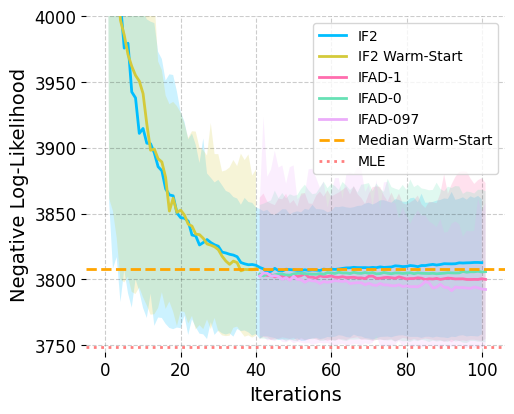

In [24]:
#IF2 0.95
quantiles = [0,0.5,0.8]
mif_runs = pd.DataFrame(mif_logliks_trials).quantile(quantiles).T.astype(float)
mif_warm_runs = pd.DataFrame(mif_logliks_warm_trials).quantile(quantiles).T.astype(float)
gd_runs = pd.DataFrame(gd_logliks_trials).quantile(quantiles).T.astype(float)
gd_mop_runs = pd.DataFrame(gd_logliks_mop_trials).quantile(quantiles).T.astype(float)
gd_pf_runs = pd.DataFrame(gd_logliks_pf_trials).quantile(quantiles).T.astype(float)
gd_runs.index += 41
gd_pf_runs.index += 41
gd_mop_runs.index += 41

plt.figure(figsize=(5,4))

mif_runs[quantiles[1]].plot(label='IF2', linestyle='solid')
mif_warm_runs[quantiles[1]].plot(label='IF2 Warm-Start', linestyle='solid')
gd_runs[quantiles[1]].plot(label='IFAD-1')
gd_pf_runs[quantiles[1]].plot(label='IFAD-0')
gd_mop_runs[quantiles[1]].plot(label='IFAD-097')

plt.fill_between(mif_runs.index,
                 mif_runs[quantiles[0]],
                mif_runs[quantiles[2]], alpha=0.2)
plt.fill_between(mif_warm_runs.index,
                 mif_warm_runs[quantiles[0]],
                mif_warm_runs[quantiles[2]], alpha=0.2)
plt.fill_between(gd_runs.index,
                 gd_runs[quantiles[0]],
                gd_runs[quantiles[2]], alpha=0.2)
plt.fill_between(gd_runs.index,
                 gd_pf_runs[quantiles[0]],
                gd_pf_runs[quantiles[2]], alpha=0.2)
plt.fill_between(gd_runs.index,
                 gd_mop_runs[quantiles[0]],
                gd_mop_runs[quantiles[2]], alpha=0.2)
plt.axhline(np.median(np.array(mif_logliks_warm_trials), 0)[-1], 
            linestyle='dashed', color='orange', alpha=1, label='Median Warm-Start')
plt.axhline(3748.5, linestyle='dotted', color='red', alpha=0.5, label='MLE')
plt.legend()
plt.ylim(3745,4000)
plt.tight_layout()
plt.xlabel('Iterations')
plt.ylabel('Negative Log-Likelihood')
#plt.title('Optimization Progress of IFAD and IF2')
plt.savefig('imgs/095/optim.png', bbox_inches='tight')

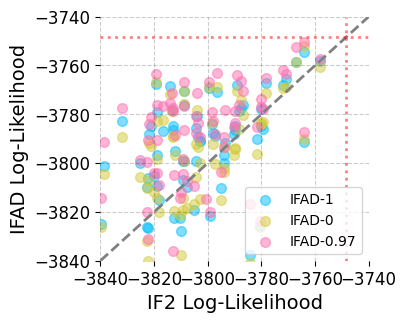

In [5]:
# IF2 0.95
plt.figure(figsize=(5/1.2,4/1.2))
# Overall paired searches, our IF2
plt.scatter(-(np.array(mif_logliks_trials)[:,-1]), -(np.array(gd_logliks_trials)[:,-1]), marker='o', alpha=0.5,
            label='IFAD-1')
plt.scatter(-(np.array(mif_logliks_trials)[:,-1]), -(np.array(gd_logliks_pf_trials)[:,-1]), marker='o', alpha=0.5,
            label='IFAD-0')
plt.scatter(-(np.array(mif_logliks_trials)[:,-1]), -(np.array(gd_logliks_mop_trials)[:,-1]), marker='o', alpha=0.5,
            label='IFAD-0.97')
lo, hi = -3840, -3740
plt.xlim(lo,hi)
plt.ylim(lo,hi)
plt.plot([lo, hi], [lo, hi], linestyle='--', color='grey')
plt.axhline(-3748.5, linestyle='dotted', color='r', alpha=0.5)
plt.axvline(-3748.5, linestyle='dotted', color='r', alpha=0.5)

#plt.title('IFAD v.s. IF2, Paired Searches')

plt.xlabel('IF2 Log-Likelihood')
plt.ylabel('IFAD Log-Likelihood')
plt.legend()
plt.tight_layout()
# put horizontal and vertical lines at 3748.5

plt.savefig('imgs/095/pairs.png', bbox_inches='tight')

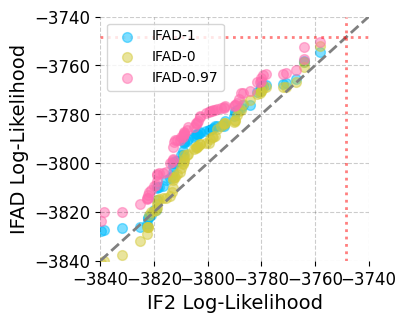

In [6]:
#IF2 0.95
#QQ plot, our IF2
plt.figure(figsize=(5/1.2,4/1.2))
plt.scatter(-np.sort(np.array(mif_logliks_trials)[:,-1]), -np.sort(np.array(gd_logliks_trials)[:,-1]), marker='o', alpha=0.5,
            label='IFAD-1')
plt.scatter(-np.sort(np.array(mif_logliks_trials)[:,-1]), -np.sort(np.array(gd_logliks_pf_trials)[:,-1]), marker='o', alpha=0.5,
            label='IFAD-0')
plt.scatter(-np.sort(np.array(mif_logliks_trials)[:,-1]), -np.sort(np.array(gd_logliks_mop_trials)[:,-1]), marker='o', alpha=0.5,
            label='IFAD-0.97')
lo, hi = -3840, -3740
plt.xlim(lo,hi)
plt.ylim(lo,hi)
plt.plot([lo, hi], [lo, hi], linestyle='--', color='grey')
plt.axhline(-3748.5, linestyle='dotted', color='r', alpha=0.5)
plt.axvline(-3748.5, linestyle='dotted', color='r', alpha=0.5)
#plt.title('IFAD v.s. IF2, Q-Q Plot')
plt.xlabel('IF2 Log-Likelihood')
plt.ylabel('IFAD Log-Likelihood')
plt.legend()
plt.tight_layout()
# put horizontal and vertical lines at 3748.5
plt.savefig('imgs/095/qq.png', bbox_inches='tight')

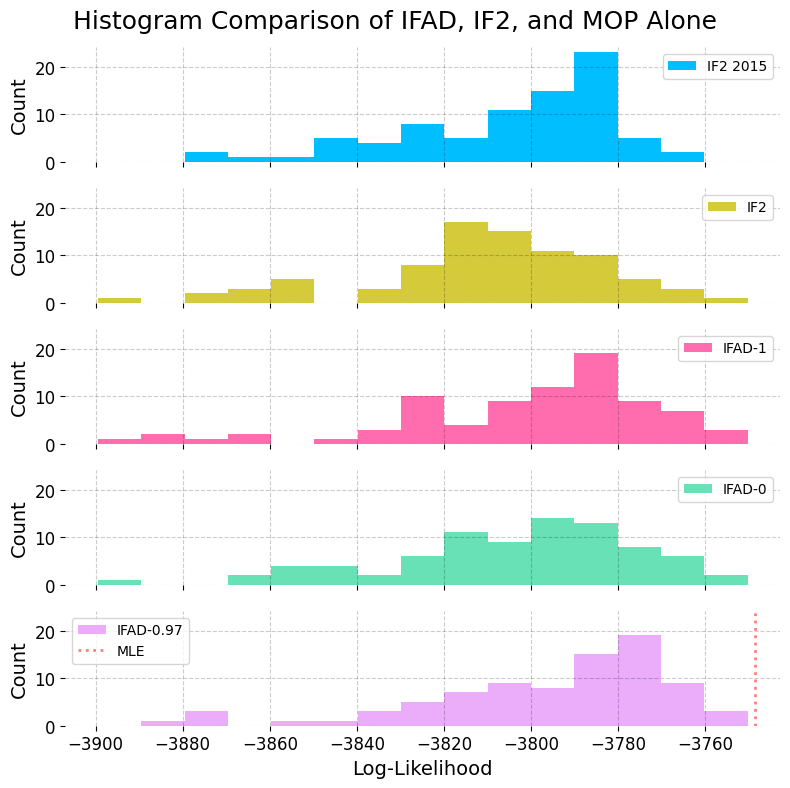

In [20]:
#IF2 0.95
import seaborn as sns
import pyreadr
from scipy.special import logsumexp
plt.style.use('matplotlibrc')
result = pyreadr.read_r('data/dacca/cholera-mif1-mif2.rda')

length = len(np.array(mif_logliks_trials))
data = pd.DataFrame({'IF2 2015': np.pad(logsumexp(result['m2.lik'], axis=0)[:length], 
                                        (0,max(0,length-100)), constant_values=np.nan),
              'IF2': -(np.array(mif_logliks_trials)[:,-1]),    
              'IFAD-1': -(np.array(gd_logliks_trials)[:,-1]),
              'IFAD-0' : -(np.array(gd_logliks_pf_trials)[:,-1]),
              'IFAD-0.97' : -(np.array(gd_logliks_mop_trials)[:,-1])})

#'IF2 Warm Start': -(np.array(mif_logliks_warm_trials)[:,-1]),  

'''
data = pd.DataFrame({'IF2 2015': np.pad(logsumexp(result['m2.lik'], axis=0)[:length], 
                                        (0,max(0,length-100)), constant_values=np.nan),
              'IF2': -(np.array(mif_logliks_trials).min(1)),
               'IF2 Warm Start': -(np.array(mif_logliks_warm_trials).min(1)),      
              'IFAD-1': -(np.array(gd_logliks_trials).min(1)),
              'IFAD-0' : -(np.array(gd_logliks_pf_trials).min(1)),
              'IFAD-0.97' : -(np.array(gd_logliks_mop_trials).min(1))})
'''

              #'MOP-1 Alone': -(np.array(gd_logliks_raw_trials)[:-2,-1]),
              #'MOP-0 Alone': -(np.array(gd_logliks_pf_raw_trials)[:-2,-1])

data[data>-3900].iloc[:,0:].plot.hist(subplots=True, figsize=(8,8),
                                       bins=15,
                                      xlabel='Log-Likelihood',
                                      ylabel='Count', 
                                     sharex=True, sharey=True)
plt.suptitle('Histogram Comparison of IFAD, IF2, and MOP Alone', fontsize=18)
plt.axvline(-3748.5, linestyle='dotted', color='r', alpha=0.5, label='MLE')
plt.legend()
plt.tight_layout()
plt.savefig('imgs/095/hist.png', bbox_inches='tight')
plt.show()

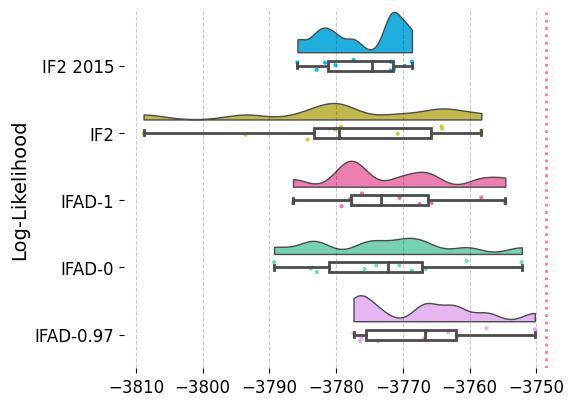

In [27]:


#IF2 0.95
import pyreadr
from scipy.special import logsumexp
import seaborn as sns
plt.style.use('matplotlibrc')


result = pyreadr.read_r('data/dacca/cholera-mif1-mif2.rda')
dx="group"; dy="score"; ort="h"; pal = "Set2"; sigma = 0.2
pal = sns.color_palette([tuple(int(h[i:i+2], 16)/255 for i in (0, 2, 4)) 
                         for h in ['00BEFF', 'D4CA3A', 'FF6DAE', '67E1B5', 'EBACFA', 
                                   '9E9E9E', 'F1988E', '5DB15A', 'E28544', '52B8AA']], 10)
fig, ax = plt.subplots(figsize=(7/1.2, 5/1.2))

ax=pt.RainCloud(x = 'variable', y = 'value', 
                data = data.rolling(10).max().iloc[9:, :][::10].melt(), bw = sigma,
                palette=pal,
                 width_viol = 1.2, ax = ax, orient = ort)
plt.xlabel('')
plt.ylabel('Log-Likelihood')


plt.axvline(-3748.5, linestyle='dotted', color='r', alpha=0.5)
plt.ylabel('Log-Likelihood')
plt.xticks(rotation=0)
#plt.title('Boxplot Comparison of Performance, Best of 10 Runs')
plt.tight_layout()
plt.savefig('imgs/095/boxplot.png', bbox_inches='tight')
plt.show()

<Figure size 500x400 with 0 Axes>

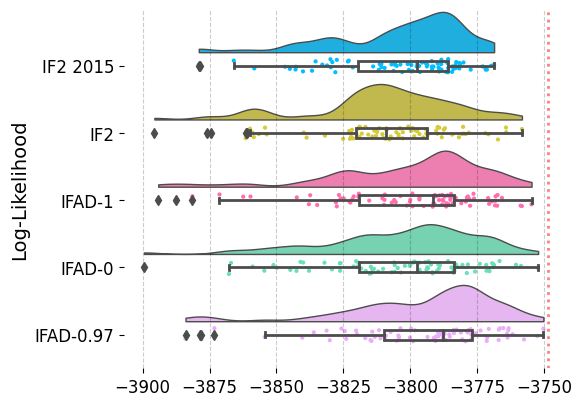

In [28]:


#IF2 0.95
import pyreadr
from scipy.special import logsumexp
import seaborn as sns
plt.style.use('matplotlibrc')
plt.figure(figsize=(5,4))
result = pyreadr.read_r('data/dacca/cholera-mif1-mif2.rda')
dx="group"; dy="score"; ort="h"; pal = "Set2"; sigma = 0.2
pal = sns.color_palette([tuple(int(h[i:i+2], 16)/255 for i in (0, 2, 4)) for h in ['00BEFF', 'D4CA3A', 'FF6DAE', '67E1B5', 'EBACFA', 
                                             '9E9E9E', 'F1988E', '5DB15A', 'E28544', '52B8AA']], 10)
fig, ax = plt.subplots(figsize=(7/1.2, 5/1.2))

ax=pt.RainCloud(x = 'variable', y = 'value', 
                data = data[data>-3900].melt(), bw = sigma,
                palette=pal,
                 width_viol = 1.2, ax = ax, orient = ort)
plt.xlabel('')
plt.ylabel('Log-Likelihood')


plt.axvline(-3748.5, linestyle='dotted', color='r', alpha=0.5)
plt.ylabel('Log-Likelihood')
plt.xticks(rotation=0)
#plt.title('Boxplot Comparison of Performance, Best of 10 Runs')
plt.tight_layout()
plt.savefig('imgs/095/boxplot_all.png', bbox_inches='tight')
plt.show()

In [23]:
pd.DataFrame({'Best Log-Likelihood': data.max(0).sort_values(ascending=False).astype(float).round(1),
              'Rank': data.max(0).rank(ascending=False).sort_values().astype(int)}).to_latex(
            'imgs/095/table.tex', index=True, float_format="{:.1f}".format)

# IF2 0.95
plt.figure(figsize=(5,4))
ax = sns.boxplot(data,
                showfliers = False)
sns.stripplot(data,
             alpha=0.2, color='black')
plt.axhline(-3748.5, linestyle='dotted', color='r', alpha=0.5)
plt.ylim(-6900,-3745)
plt.xticks(rotation=45)
plt.ylabel('Log-Likelihood')
#plt.title('Boxplot Comparison of Performance, All Methods')
plt.tight_layout()
plt.savefig('imgs/095/boxplotall.png', bbox_inches='tight')
plt.show()

#IF2 0.95
import pyreadr
from scipy.special import logsumexp
import seaborn as sns
plt.style.use('matplotlibrc')
plt.figure(figsize=(5,4))
result = pyreadr.read_r('data/dacca/cholera-mif1-mif2.rda')
ax = sns.boxplot(data.rolling(10).max().iloc[9:, :][::10],
                showfliers = False)
sns.stripplot(data.rolling(10).max().iloc[9:, :][::10],
             alpha=0.2, color='black')
plt.axhline(-3748.5, linestyle='dotted', color='r', alpha=0.5)
plt.ylabel('Log-Likelihood')
plt.xticks(rotation=45)
#plt.title('Boxplot Comparison of Performance, Best of 10 Runs')
plt.tight_layout()
plt.savefig('imgs/095/boxplot.png', bbox_inches='tight')
plt.show()